In [1]:
pip install -q datasets transformers evaluate timm albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00


In [2]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.9 MB/s eta 0:00:00


In [3]:
!pip install datasets

# Load Data


In [4]:
# 1. Read the COCO formatted annotations to a dict
import json
with open('result.json') as f:
 cocodata = json.load(f)

In [5]:
# 2. Convert the COCO formatted dict to a format readable by dataset.load_dataset().
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
 # Remove the image directory from the file name
 image['file_name'] = image['file_name'].split('/')[-1]
 image['image_id'] = image['id']
 # Extend the image dict with bounding boxes and class labels
 image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
 # Iterate through the annotations (bounding boxes and labels)
 for annot in cocodata['annotations']:
  # Check if the annotation matches the image
  if annot['image_id'] == image['id']:
    # Add the annotation
    image['objects']['bbox'].append(annot['bbox'])
    image['objects']['category'].append(annot['category_id'])
    image['objects']['area'].append(annot['area'])
    image['objects']['id'].append(annot['id'])
 # Append the image dict with annotations to the list
 huggingdata.append(image)

In [6]:
# 3. Write the Huggingface formatted annotations to a json file.
with open("metadata.jsonl", 'w') as f:
 for item in huggingdata:
  f.write(json.dumps(item) + "\n")

In [7]:
# 4, Organize the images and metadata.jsonl into the correct folder structure.
# 5. Read the data into a DatasetDict.
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/data")

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-3d2369ac497f527c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

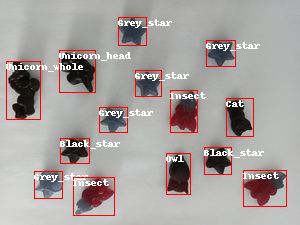

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = dataset["train"][0]["image"]
annotations = dataset["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = dataset["train"].features["objects"]["category"]

id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), str(id2label[class_idx]), fill="white")

image

# Preprocess the data

In [9]:
from transformers import AutoImageProcessor
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [10]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [12]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [13]:
dataset["train"] = dataset["train"].with_transform(transform_aug_ann)

In [14]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

# Training the DETR model

In [15]:
# To convert from ids to labels and back again (labels to ids) you can use this snippet:
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

In [16]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/result",
    per_device_train_batch_size=8,
    num_train_epochs=200,
    fp16=True,
    save_steps=200,
    logging_steps=20,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
This method is deprecated and will be removed in v4.27.0. Please use pad instead.


Step,Training Loss
20,2.772000
40,2.191500
60,1.778000
80,1.525100
100,1.356100
120,1.123100
140,0.986400
160,0.797600
180,0.687000
200,0.611800


TrainOutput(global_step=400, training_loss=0.9094161581993103, metrics={'train_runtime': 324.3078, 'train_samples_per_second': 6.167, 'train_steps_per_second': 1.233, 'total_flos': 9.5582631168e+17, 'train_loss': 0.9094161581993103, 'epoch': 200.0})

# Evaluate

In [19]:
trainer.save_model('candy_detector')

In [85]:
def candy_counter(image, model_path='/content/candy_detector'):
    image_path = '/content/images/cd_07.jpg'
    image = Image.open(image_path)
    candy_dict = {label: 0 for label in ['Moon', 'Insect', 'Black_star', 'Grey_star', 'Unicorn_whole', 'Unicorn_head', 'Owl', 'Cat']}
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModelForObjectDetection.from_pretrained(model_path)

    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        label = model.config.id2label[label.item()]

        if label not in candy_dict:
            candy_dict[label] = 1
        else:
            candy_dict[label] += 1

    # Printing out the results dictionary
    print(candy_dict)

    # Showing the predicted bounding boxes and labels for the test image
    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        x, y, x2, y2 = tuple(box)
        draw.rectangle((x, y, x2, y2), outline="red", width=1)
        draw.text((x, y), model.config.id2label[label.item()], fill="white")

    image.show()

{'Moon': 2, 'Insect': 3, 'Black_star': 5, 'Grey_star': 0, 'Unicorn_whole': 1, 'Unicorn_head': 1, 'Owl': 6, 'Cat': 0}


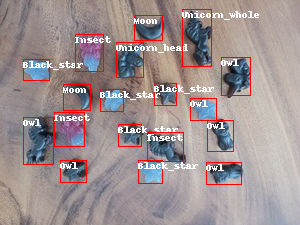

In [86]:
candy_counter(image)